In [1]:
# Step 1: Load and Preprocess Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [3]:
# Merge datasets
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
merged_data = transactions.merge(customers, on='CustomerID')

In [5]:
# Step 2: Feature Engineering
# Aggregate transaction data at the customer level
customer_metrics = merged_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    unique_products=('ProductID', 'nunique'),
    total_transactions=('TransactionID', 'nunique'),
    # Calculate account age in days using the first SignupDate for each customer
    account_age_days=('SignupDate', lambda x: (pd.Timestamp.now() - x.min()).days),
    region=('Region', 'first')
).reset_index()

In [6]:
# Encode categorical features (Region)
customer_metrics = pd.get_dummies(customer_metrics, columns=['region'], drop_first=True)


In [7]:
# Step 3: Scale Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_metrics.iloc[:, 1:])  # Exclude CustomerID

In [8]:
# Step 4: Apply Clustering
# Experiment with different cluster numbers
db_scores = []
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Choose optimal number of clusters (lowest DB Index)
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters (based on DB Index): {optimal_k}")

Optimal Number of Clusters (based on DB Index): 8


In [25]:
# Final Clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)
customer_metrics['Cluster'] = final_labels

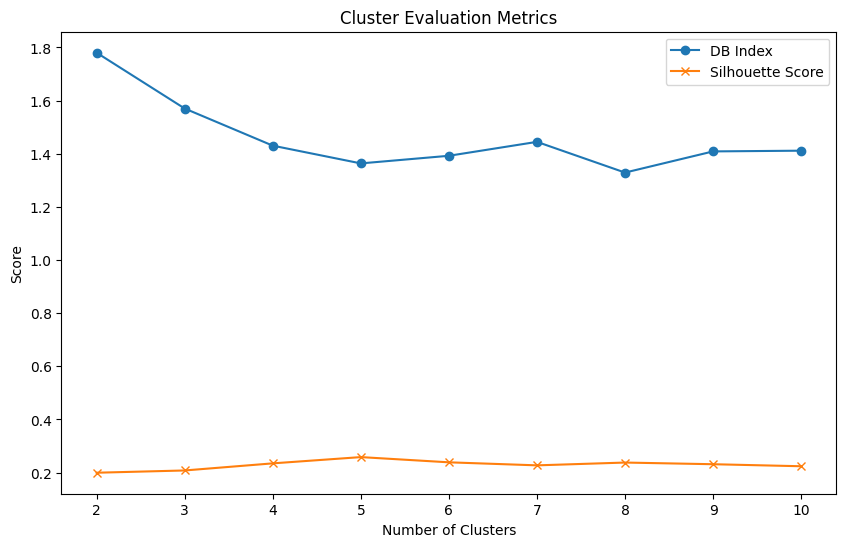

In [26]:
# Step 5: Visualization
# 1. DB Index and Silhouette Score trends
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, marker='o', label='DB Index')
plt.plot(k_range, silhouette_scores, marker='x', label='Silhouette Score')
plt.title('Cluster Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

<ipython-input-27-5bf410791aac>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=customer_metrics, palette='viridis')


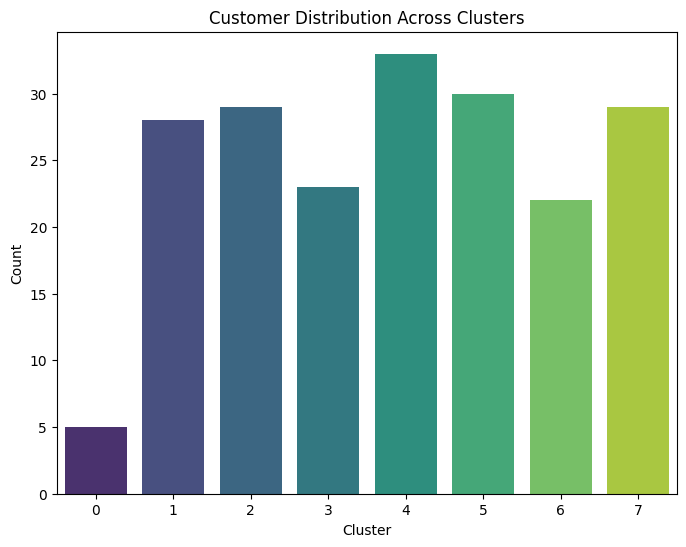

In [27]:
# 2. Cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=customer_metrics, palette='viridis')
plt.title('Customer Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

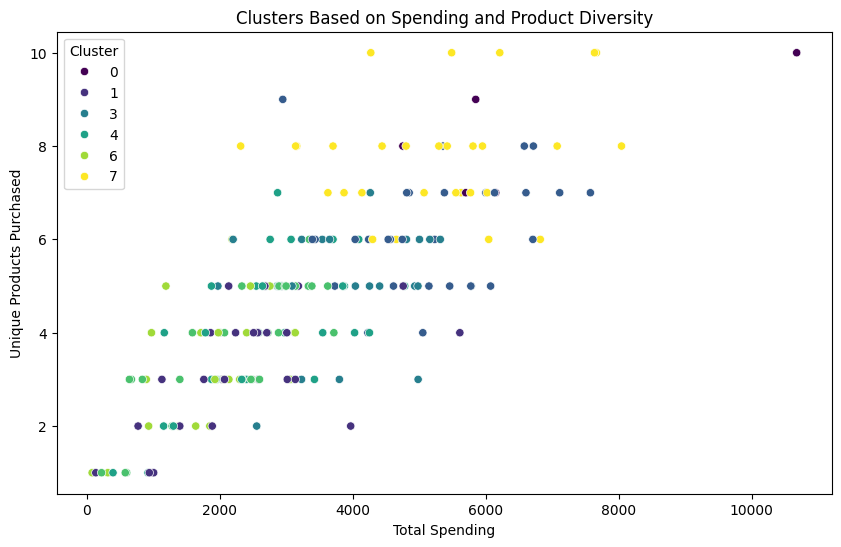

In [28]:
# 3. Scatter plot of two features
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_metrics['total_spending'],
    y=customer_metrics['unique_products'],
    hue=customer_metrics['Cluster'],
    palette='viridis'
)
plt.title('Clusters Based on Spending and Product Diversity')
plt.xlabel('Total Spending')
plt.ylabel('Unique Products Purchased')
plt.legend(title='Cluster')
plt.show()

In [29]:
# Step 6: Report
# Calculate final DB Index and Silhouette Score
final_db_index = davies_bouldin_score(scaled_features, final_labels)
final_silhouette = silhouette_score(scaled_features, final_labels)
print(f"\nFinal DB Index: {final_db_index:.2f}")
print(f"Final Silhouette Score: {final_silhouette:.2f}")


Final DB Index: 1.33
Final Silhouette Score: 0.24


In [30]:
# Save cluster results
customer_metrics.to_csv('Customer_Clusters.csv', index=False)
print("\nClustering Results Saved to 'Customer_Clusters.csv'")


Clustering Results Saved to 'Customer_Clusters.csv'
